***Right lane changes from comma2k19***

In [1]:
import numpy as np
import zCurve as z

def calculateMortonFromTwoLatLonFloats_with_zCurve(x, y):
    # Cap floating point numbers to six decimal places
    x_int = int( round( (x + 90.0), 6 ) * 100000 )
    y_int = int( round( (y + 180.0), 6 ) * 100000 )
    value = z.interlace(x_int, y_int, dims=2)
    return value
    
def mortonEncode2D(a, b):
    x = np.uint64(a)
    y = np.uint64(b)

    x = (x | (x << np.uint64(16))) & np.uint64(0x0000FFFF0000FFFF)
    x = (x | (x << np.uint64(8)))  & np.uint64(0x00FF00FF00FF00FF)
    x = (x | (x << np.uint64(4)))  & np.uint64(0x0F0F0F0F0F0F0F0F)
    x = (x | (x << np.uint64(2)))  & np.uint64(0x3333333333333333)
    x = (x | (x << np.uint64(1)))  & np.uint64(0x5555555555555555)

    y = (y | (y << np.uint64(16))) & np.uint64(0x0000FFFF0000FFFF)
    y = (y | (y << np.uint64(8)))  & np.uint64(0x00FF00FF00FF00FF)
    y = (y | (y << np.uint64(4)))  & np.uint64(0x0F0F0F0F0F0F0F0F)
    y = (y | (y << np.uint64(2)))  & np.uint64(0x3333333333333333)
    y = (y | (y << np.uint64(1)))  & np.uint64(0x5555555555555555)

    result = np.uint64( x | (y << np.uint64(1)) )
    return result

def mortonExtractEvenBits(a):
    x = np.uint64(a)
    
    x = x & np.uint64(0x5555555555555555)
    x = (x | (x >> np.uint64(1)))  & np.uint64(0x3333333333333333)
    x = (x | (x >> np.uint64(2)))  & np.uint64(0x0F0F0F0F0F0F0F0F)
    x = (x | (x >> np.uint64(4)))  & np.uint64(0x00FF00FF00FF00FF)
    x = (x | (x >> np.uint64(8)))  & np.uint64(0x0000FFFF0000FFFF)
    x = (x | (x >> np.uint64(16))) & np.uint64(0x00000000FFFFFFFF)
    
    return x.astype(np.uint32)

def mortonDecode2D(a):
    _a = np.uint64(a)
    
    x = mortonExtractEvenBits(_a)
    y = mortonExtractEvenBits(_a >> np.uint64(1))
    
    return (x, y)

def calculateMortonFromTwoLatLonFloats(x, y):
    _x = np.float32(x)
    _y = np.float32(y)
    # Cap floating point numbers to six decimal places.
    x_int = np.uint32( np.round( (_x + np.float32(90.0) ), 6 ) * np.uint32(100000) )
    y_int = np.uint32( np.round( (_y + np.float32(180.0) ), 6 ) * np.uint32(100000) )
    value = mortonEncode2D(x_int, y_int)
    return value

def calculateTwoLatLonFloatsFromMorton(a):
    pair = mortonDecode2D(a)
    _x = np.float32(pair[0] / np.float32(100000.0) - np.float32(90.0))
    _y = np.float32(pair[1] / np.float32(100000.0) - np.float32(180.0))
    return (_x, _y)


def calculateMortonFromXYAccelerationFloats(x, y):
    _x = np.float32(x)
    _y = np.float32(y)
    # Cap floating point numbers to six decimal places.
    x_int = np.uint32( np.round( (_x + np.float32(10.0) ), 6 ) * np.uint32(100) )
    y_int = np.uint32( np.round( (_y + np.float32(10.0) ), 6 ) * np.uint32(100) )
    value = mortonEncode2D(x_int, y_int)
    return value

def calculateXYAccelerationFloatsFromMorton(a):
    pair = mortonDecode2D(a)
    _x = np.float32(pair[0] / np.float32(100.0) - np.float32(10.0))
    _y = np.float32(pair[1] / np.float32(100.0) - np.float32(10.0))
    return (_x, _y)

Set 40 from chunk2

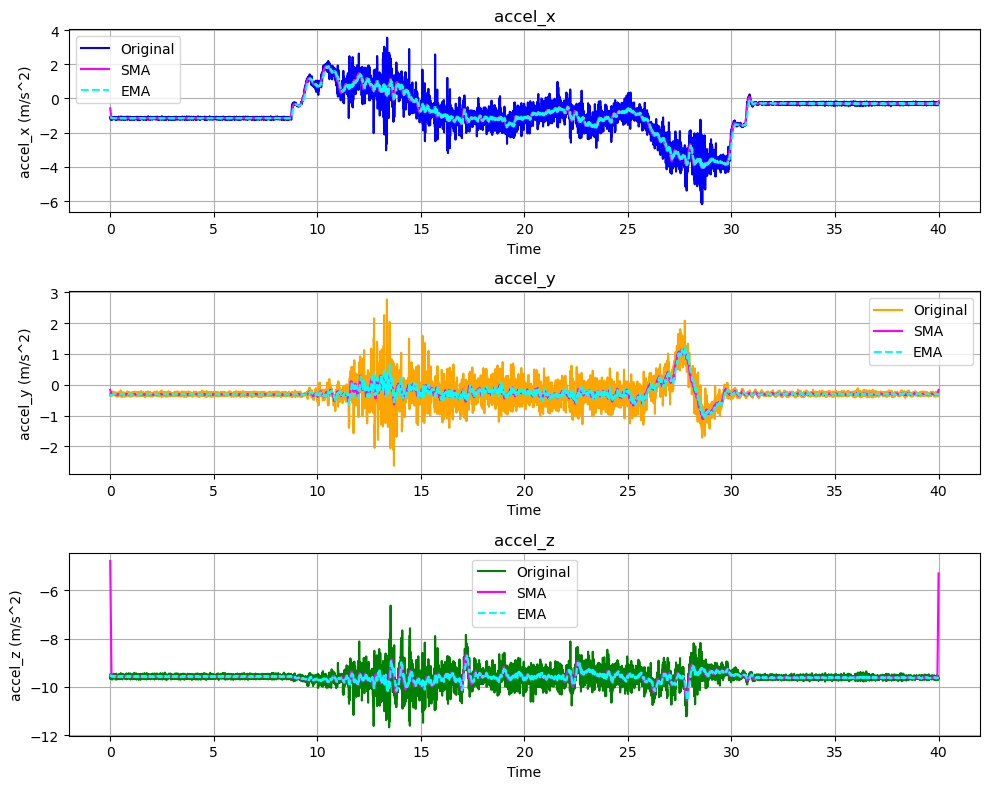

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas for EMA calculation

# Function to read the binary file containing acceleration data
# Assuming you have these files, otherwise this code won't run as is
data_value = np.load('value40_2018-10-22--11-21-08')
data_t = np.load('t40_2018-10-22--11-21-08')


# Assuming data_t is a 1D array of timestamps
# Find the minimum and maximum timestamps
min_time = np.min(data_t)
max_time = np.max(data_t)

# Calculate the range of time
time_range = max_time - min_time

# Normalize the time data to be between 0 and 40 seconds
data_t_normalized = ((data_t - min_time) / time_range) * 40
data_t_list = data_t_normalized.tolist()

df_time =  pd.DataFrame(data_t_list, columns=['timestamp'])


# Extracting individual components of acceleration
accel_x = data_value[:, 0]
accel_y = data_value[:, 1]
accel_z = data_value[:, 2]


# Simple Moving Average Function
def simple_moving_average(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

# Exponential Moving Average Function
def exponential_moving_average(data, window_size):
    return pd.Series(data).ewm(span=window_size, adjust=False).mean().to_numpy()


# Applying SMA and EMA
window_size = 20  # Example window size
sma_accel_x = simple_moving_average(accel_x, window_size)
ema_accel_x = exponential_moving_average(accel_x, window_size)
 
sma_accel_y = simple_moving_average(accel_y, window_size)
ema_accel_y = exponential_moving_average(accel_y, window_size)
 
sma_accel_z = simple_moving_average(accel_z, window_size)
ema_accel_z = exponential_moving_average(accel_z, window_size)

 
# Plotting the acceleration data with SMA and EMA
plt.figure(figsize=(10, 8))


titles = ['accel_x', 'accel_y', 'accel_z']
colors = ['blue', 'orange', 'green']
data_sets = [(accel_x, sma_accel_x, ema_accel_x),
             (accel_y, sma_accel_y, ema_accel_y),
             (accel_z, sma_accel_z, ema_accel_z)]


for i, (data, sma_data, ema_data) in enumerate(data_sets):
    plt.subplot(3, 1, i+1)
    plt.plot(data_t_normalized, data, label='Original', color=colors[i])
    plt.plot(data_t_normalized, sma_data, label='SMA', color='magenta')
    plt.plot(data_t_normalized, ema_data, label='EMA', color='cyan', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel(f'{titles[i]} (m/s^2)')
    plt.title(titles[i])
    plt.legend()
    plt.grid(True)


plt.tight_layout()
plt.show()



In [3]:
# Combine the data in a list
combined_data = list(zip( accel_y, data_t_normalized))

series2_data = data_value[:, 1]
set40 = []
set40_A = []
set40_B = []
time40 = []
group_A = []
group_B = []
counter = 0
group_RA = []
group_RB = []
x = 0


for data_point, time in combined_data :
    if time > 25 and time < 32:
        if data_point < -1  or data_point > 0.09:
            morton = calculateMortonFromXYAccelerationFloats(x, data_point)
            set40_A.append(morton)
            time_norm = time -25
            set40.append({'morton': morton, 'timestamp':time_norm})
            group_A.append(morton)
            group_RA.append(morton)
        else:
            morton = calculateMortonFromXYAccelerationFloats(x, data_point)
            set40_B.append(morton)
            time_norm = time -25
            set40.append({'morton': morton, 'timestamp':time_norm})
            group_B.append(morton)
            group_RB.append(morton)

    
df_set40 = pd.DataFrame(set40, columns=['morton','timestamp'])
print(df_set40)




       morton  timestamp
0     1045736   0.001585
1     1045570   0.007995
2     1039466   0.014406
3     1039586   0.020796
4     1045578   0.027186
...       ...        ...
1090  1046090   6.973115
1091  1045698   6.979505
1092  1045738   6.985916
1093  1045706   6.992305
1094  1046120   6.998695

[1095 rows x 2 columns]


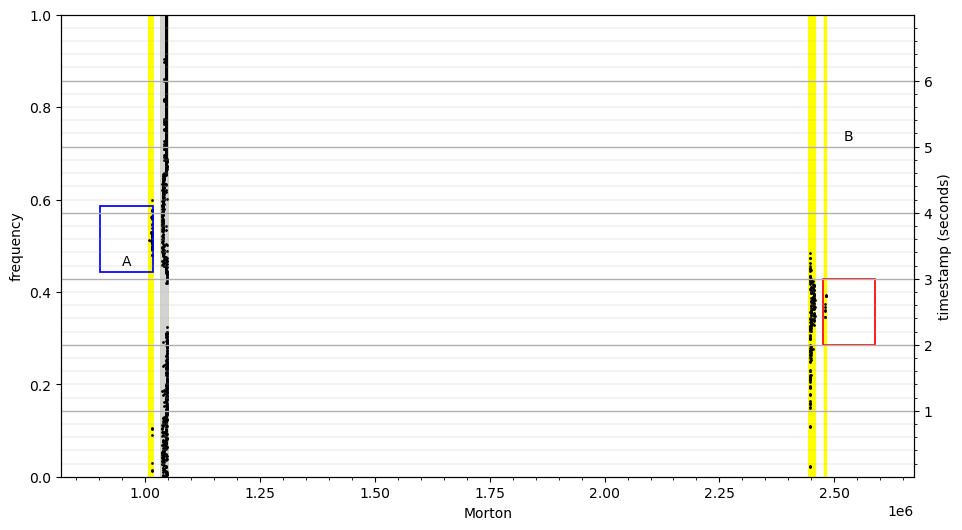

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as patches

data1 = [set40_A, set40_B]
data_colors = ['yellow', 'lightgray']

morton40 = df_set40['morton']
timestamp_seconds = df_set40['timestamp']



plt.figure(figsize=(11, 6))  # Adjust figure size as needed
plt.xlabel('Morton')
plt.ylabel('frequency')
plt.ylim((0, 1))
#plt.xticks(np.arange(min(morton40), max(morton40), 0.5e6))

#Plot the occurrences as vertical lines instead of horizontal
#plt.vlines(morton40, 0, 1, colors='lightgrey', linestyles='solid',linewidth = 4)
plt.eventplot(data1, orientation='horizontal', colors= data_colors, lineoffsets=[0.5, 0.5])
#Create a second y-axis for the timestamps
ax2 = plt.twinx()
ax2.set_ylabel('timestamp (seconds)')
#Set the limit for the timestamp y-axis to align with the data
ax2.set_ylim([min(timestamp_seconds), max(timestamp_seconds)])
ax2.grid(which = "major", linewidth = 1)
ax2.grid(which = "minor", linewidth = 0.2)
ax2.minorticks_on()
#plt.ylim(22, 29.4) #Zoomed in where we think the lane change is happening 
#plt.xlim(1.03e6, 1.05e6)
#Plot the timestamps on this new y-axis, aligned with the occurrences on the left y-axis
ax2.scatter(morton40, timestamp_seconds, color='black', s=1)  # Adjust size of dots


# Draw boxes 
plt.text(0.95*1e6, 3.2, 'A')
lower = plt.Rectangle( (0.902*1e6, 3.1), 1.14e5, 1, linewidth=1.25, edgecolor="blue", facecolor='none')
plt.text(2.52*1e6, 5.1, 'B')
upper = plt.Rectangle( (2.475*1e6, 2), 1.14e5, 1, linewidth=1.25, edgecolor="red", facecolor='none')

plt.gca().add_patch(lower)
plt.gca().add_patch(upper)


plt.show()

2.1 sec long; threshold -1.5 and 1.5

Set 3 from chunk 1

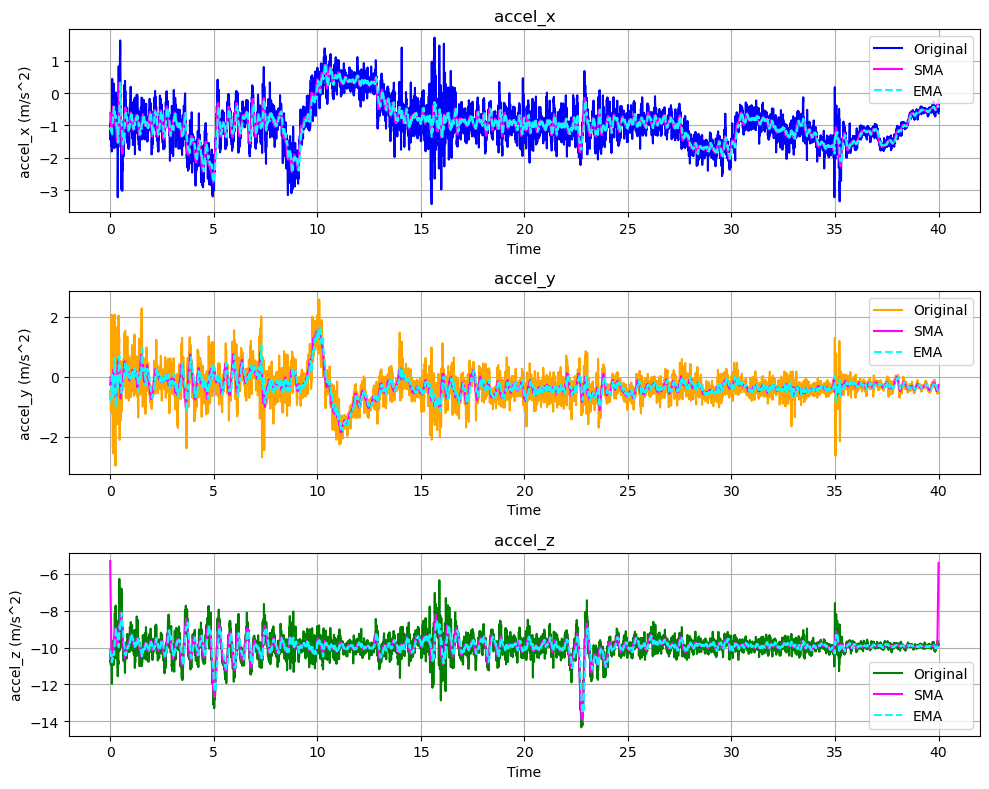

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas for EMA calculation

# Function to read the binary file containing acceleration data
# Assuming you have these files, otherwise this code won't run as is
data_value = np.load('value3')
data_t = np.load('t3')


# Assuming data_t is a 1D array of timestamps
# Find the minimum and maximum timestamps
min_time = np.min(data_t)
max_time = np.max(data_t)

# Calculate the range of time
time_range = max_time - min_time

# Normalize the time data to be between 0 and 40 seconds
data_t_normalized = ((data_t - min_time) / time_range) * 40
data_t_list = data_t_normalized.tolist()

df_time =  pd.DataFrame(data_t_list, columns=['timestamp'])


# Extracting individual components of acceleration
accel_x = data_value[:, 0]
accel_y = data_value[:, 1]
accel_z = data_value[:, 2]


# Simple Moving Average Function
def simple_moving_average(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

# Exponential Moving Average Function
def exponential_moving_average(data, window_size):
    return pd.Series(data).ewm(span=window_size, adjust=False).mean().to_numpy()


# Applying SMA and EMA
window_size = 20  # Example window size
sma_accel_x = simple_moving_average(accel_x, window_size)
ema_accel_x = exponential_moving_average(accel_x, window_size)
 
sma_accel_y = simple_moving_average(accel_y, window_size)
ema_accel_y = exponential_moving_average(accel_y, window_size)
 
sma_accel_z = simple_moving_average(accel_z, window_size)
ema_accel_z = exponential_moving_average(accel_z, window_size)

 
# Plotting the acceleration data with SMA and EMA
plt.figure(figsize=(10, 8))


titles = ['accel_x', 'accel_y', 'accel_z']
colors = ['blue', 'orange', 'green']
data_sets = [(accel_x, sma_accel_x, ema_accel_x),
             (accel_y, sma_accel_y, ema_accel_y),
             (accel_z, sma_accel_z, ema_accel_z)]


for i, (data, sma_data, ema_data) in enumerate(data_sets):
    plt.subplot(3, 1, i+1)
    plt.plot(data_t_normalized, data, label='Original', color=colors[i])
    plt.plot(data_t_normalized, sma_data, label='SMA', color='magenta')
    plt.plot(data_t_normalized, ema_data, label='EMA', color='cyan', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel(f'{titles[i]} (m/s^2)')
    plt.title(titles[i])
    plt.legend()
    plt.grid(True)


plt.tight_layout()
plt.show()



In [6]:
# Combine the data in a list
combined_data = list(zip( accel_y, data_t_normalized))

series2_data = data_value[:, 1]
set3 = []
set3_A = []
set3_B = []
x = 0


for data_point, time in combined_data :
    if time > 7.5 and time < 14.5:
        if data_point < -1 or data_point > 0.09 : # 1.5
            morton = calculateMortonFromXYAccelerationFloats(x, data_point)
            set3_A.append(morton)
            time_norm = time -7.5
            set3.append({'morton': morton, 'timestamp':time_norm})
            group_A.append(morton)
        else:
            morton = calculateMortonFromXYAccelerationFloats(x, data_point)
            set3_B.append(morton)
            time_norm = time -7.5
            set3.append({'morton': morton, 'timestamp':time_norm})
            group_B.append(morton)


    
df_set3 = pd.DataFrame(set3, columns=['morton','timestamp'])
print(df_set3)




       morton  timestamp
0     1039946   0.002356
1     1045600   0.009010
2     1040072   0.015664
3     1040104   0.018920
4     1039552   0.022318
...       ...        ...
1152  1045698   6.968983
1153  1045602   6.975637
1154  1045698   6.982291
1155  1046120   6.988944
1156  1046112   6.995598

[1157 rows x 2 columns]


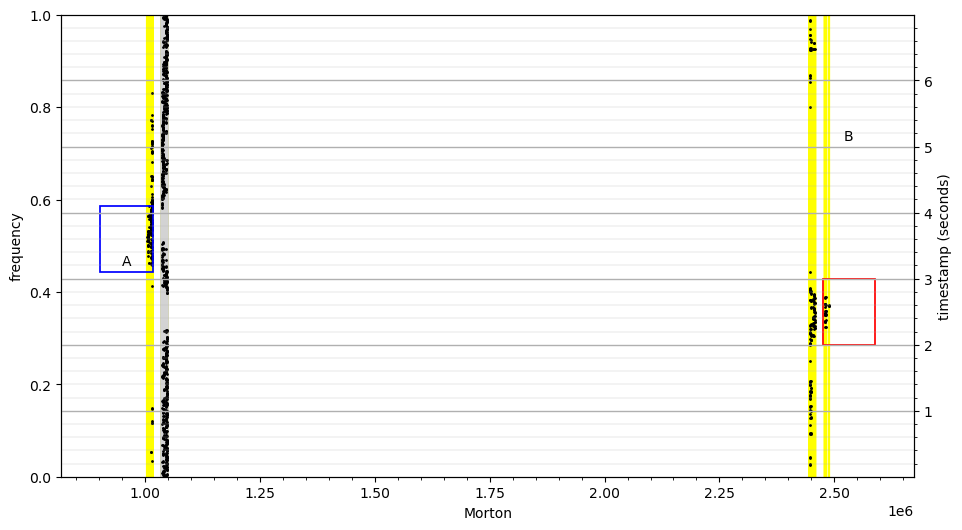

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as patches

data1 = [set3_A, set3_B]
data_colors = ['yellow', 'lightgray']

morton3 = df_set3['morton']
timestamp_seconds = df_set3['timestamp']



plt.figure(figsize=(11, 6))  # Adjust figure size as needed
plt.xlabel('Morton')
plt.ylabel('frequency')
plt.ylim((0, 1))
#plt.xticks(np.arange(min(morton40), max(morton40), 0.5e6))

#Plot the occurrences as vertical lines instead of horizontal
#plt.vlines(morton40, 0, 1, colors='lightgrey', linestyles='solid',linewidth = 4)
plt.eventplot(data1, orientation='horizontal', colors= data_colors, lineoffsets=[0.5, 0.5])
#Create a second y-axis for the timestamps
ax2 = plt.twinx()
ax2.set_ylabel('timestamp (seconds)')
#Set the limit for the timestamp y-axis to align with the data
ax2.set_ylim([min(timestamp_seconds), max(timestamp_seconds)])
ax2.grid(which = "major", linewidth = 1)
ax2.grid(which = "minor", linewidth = 0.2)
ax2.minorticks_on()
#plt.ylim(22, 29.4) #Zoomed in where we think the lane change is happening 
#plt.xlim(1.03e6, 1.05e6)
#Plot the timestamps on this new y-axis, aligned with the occurrences on the left y-axis
ax2.scatter(morton3, timestamp_seconds, color='black', s=1)  # Adjust size of dots



# Draw boxes 
plt.text(0.95*1e6, 3.2, 'A')
lower = plt.Rectangle( (0.902*1e6, 3.1), 1.14e5, 1, linewidth=1.25, edgecolor="blue", facecolor='none')
plt.text(2.52*1e6, 5.1, 'B')
upper = plt.Rectangle( (2.475*1e6, 2), 1.14e5, 1, linewidth=1.25, edgecolor="red", facecolor='none')

plt.gca().add_patch(lower)
plt.gca().add_patch(upper)

plt.show()

2.1 sec long; threshold -1.5 and 1.5

Set 7 from chunk 1

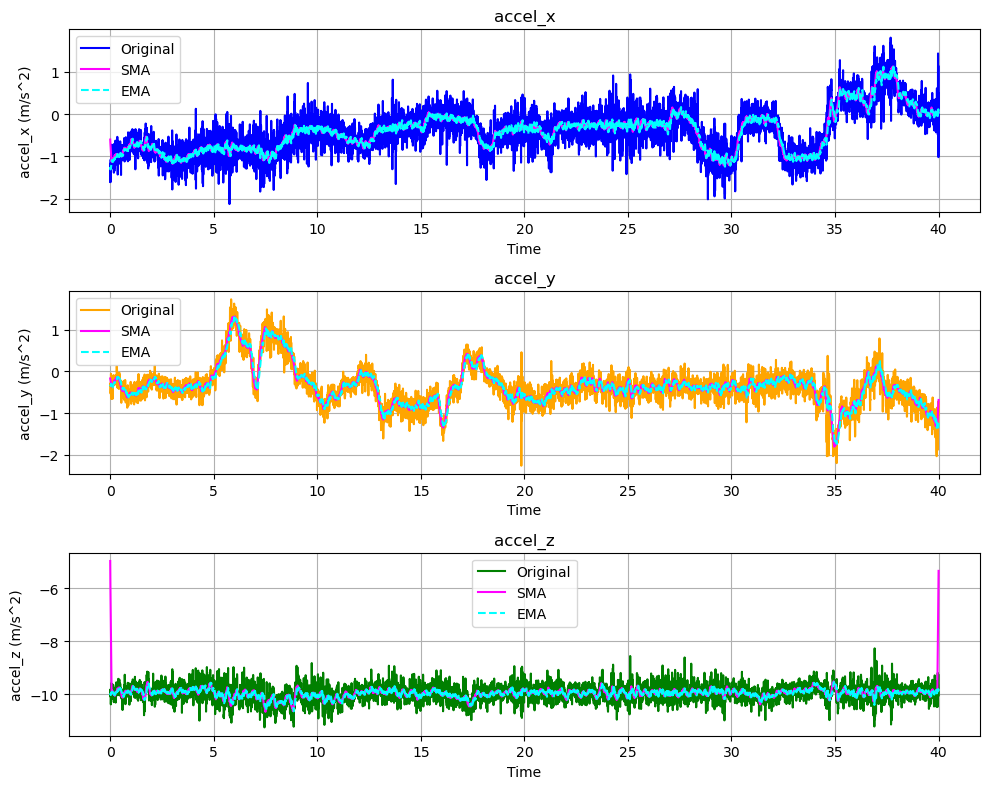

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas for EMA calculation

# Function to read the binary file containing acceleration data
# Assuming you have these files, otherwise this code won't run as is
data_value = np.load('value7')
data_t = np.load('t7')


# Assuming data_t is a 1D array of timestamps
# Find the minimum and maximum timestamps
min_time = np.min(data_t)
max_time = np.max(data_t)

# Calculate the range of time
time_range = max_time - min_time

# Normalize the time data to be between 0 and 40 seconds
data_t_normalized = ((data_t - min_time) / time_range) * 40
data_t_list = data_t_normalized.tolist()

df_time =  pd.DataFrame(data_t_list, columns=['timestamp'])


# Extracting individual components of acceleration
accel_x = data_value[:, 0]
accel_y = data_value[:, 1]
accel_z = data_value[:, 2]


# Simple Moving Average Function
def simple_moving_average(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

# Exponential Moving Average Function
def exponential_moving_average(data, window_size):
    return pd.Series(data).ewm(span=window_size, adjust=False).mean().to_numpy()


# Applying SMA and EMA
window_size = 20  # Example window size
sma_accel_x = simple_moving_average(accel_x, window_size)
ema_accel_x = exponential_moving_average(accel_x, window_size)
 
sma_accel_y = simple_moving_average(accel_y, window_size)
ema_accel_y = exponential_moving_average(accel_y, window_size)
 
sma_accel_z = simple_moving_average(accel_z, window_size)
ema_accel_z = exponential_moving_average(accel_z, window_size)

 
# Plotting the acceleration data with SMA and EMA
plt.figure(figsize=(10, 8))


titles = ['accel_x', 'accel_y', 'accel_z']
colors = ['blue', 'orange', 'green']
data_sets = [(accel_x, sma_accel_x, ema_accel_x),
             (accel_y, sma_accel_y, ema_accel_y),
             (accel_z, sma_accel_z, ema_accel_z)]


for i, (data, sma_data, ema_data) in enumerate(data_sets):
    plt.subplot(3, 1, i+1)
    plt.plot(data_t_normalized, data, label='Original', color=colors[i])
    plt.plot(data_t_normalized, sma_data, label='SMA', color='magenta')
    plt.plot(data_t_normalized, ema_data, label='EMA', color='cyan', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel(f'{titles[i]} (m/s^2)')
    plt.title(titles[i])
    plt.legend()
    plt.grid(True)


plt.tight_layout()
plt.show()



In [9]:
# Combine the data in a list
combined_data = list(zip( accel_y, data_t_normalized))

series2_data = data_value[:, 1]
set7 = []
set7_A = []
set7_B = []
x = 0


for data_point, time in combined_data :
    if time > 15 and time < 22:
        if data_point < -1 or data_point > 0.09:
            morton = calculateMortonFromXYAccelerationFloats(x, data_point)
            set7_A.append(morton)
            time_norm = time -15
            set7.append({'morton': morton, 'timestamp':time_norm})
            group_A.append(morton)
        else:
            morton = calculateMortonFromXYAccelerationFloats(x, data_point)
            set7_B.append(morton)
            time_norm = time -15
            set7.append({'morton': morton, 'timestamp':time_norm})
            group_B.append(morton)


    
df_set7 = pd.DataFrame(set7, columns=['morton','timestamp'])
print(df_set7)




       morton  timestamp
0     1039584   0.001297
1     1038018   0.007951
2     1015402   0.014605
3     1015394   0.021259
4     1037538   0.027913
...       ...        ...
1152  1045578   6.967945
1153  1045578   6.974599
1154  1045570   6.981253
1155  1045568   6.987907
1156  1038050   6.994561

[1157 rows x 2 columns]


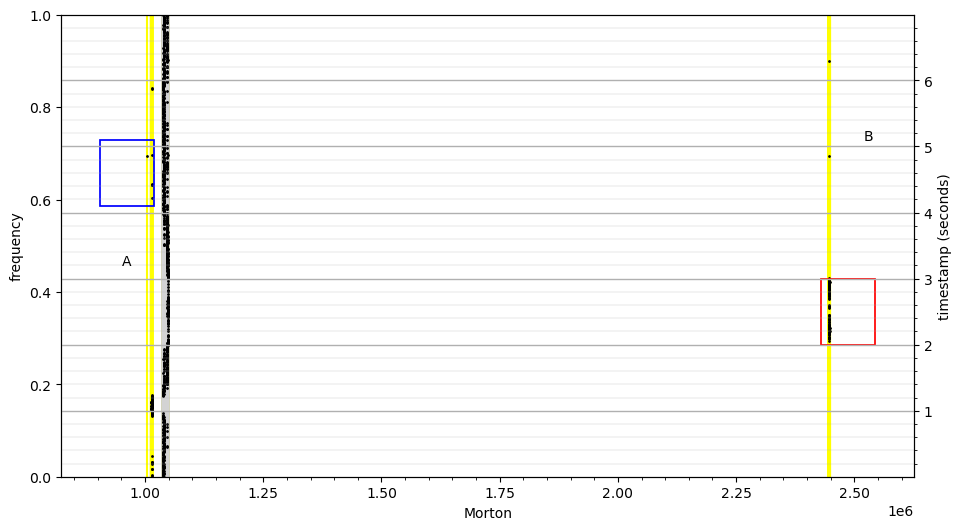

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as patches

data1 = [set7_A, set7_B]
data_colors = ['yellow', 'lightgray']

morton7 = df_set7['morton']
timestamp_seconds = df_set7['timestamp']



plt.figure(figsize=(11, 6))  # Adjust figure size as needed
plt.xlabel('Morton')
plt.ylabel('frequency')
plt.ylim((0, 1))
#plt.xticks(np.arange(min(morton40), max(morton40), 0.5e6))

#Plot the occurrences as vertical lines instead of horizontal
#plt.vlines(morton40, 0, 1, colors='lightgrey', linestyles='solid',linewidth = 4)
plt.eventplot(data1, orientation='horizontal', colors= data_colors, lineoffsets=[0.5, 0.5])
#Create a second y-axis for the timestamps
ax2 = plt.twinx()
ax2.set_ylabel('timestamp (seconds)')
#Set the limit for the timestamp y-axis to align with the data
ax2.set_ylim([min(timestamp_seconds), max(timestamp_seconds)])
ax2.grid(which = "major", linewidth = 1)
ax2.grid(which = "minor", linewidth = 0.2)
ax2.minorticks_on()
#plt.ylim(22, 29.4) #Zoomed in where we think the lane change is happening 
#plt.xlim(1.03e6, 1.05e6)
#Plot the timestamps on this new y-axis, aligned with the occurrences on the left y-axis
ax2.scatter(morton7, timestamp_seconds, color='black', s=1)  # Adjust size of dots



# Draw boxes 
plt.text(0.95*1e6, 3.2, 'A')
lower = plt.Rectangle( (0.905*1e6, 4.1), 1.14e5, 1, linewidth=1.25, edgecolor="blue", facecolor='none')
plt.text(2.52*1e6, 5.1, 'B')
upper = plt.Rectangle( (2.43*1e6, 2), 1.14e5, 1, linewidth=1.25, edgecolor="red", facecolor='none')

plt.gca().add_patch(lower)
plt.gca().add_patch(upper)


plt.show()

3.1 sec long; threshold -1 and 0.09

Set 10 from chunk 1

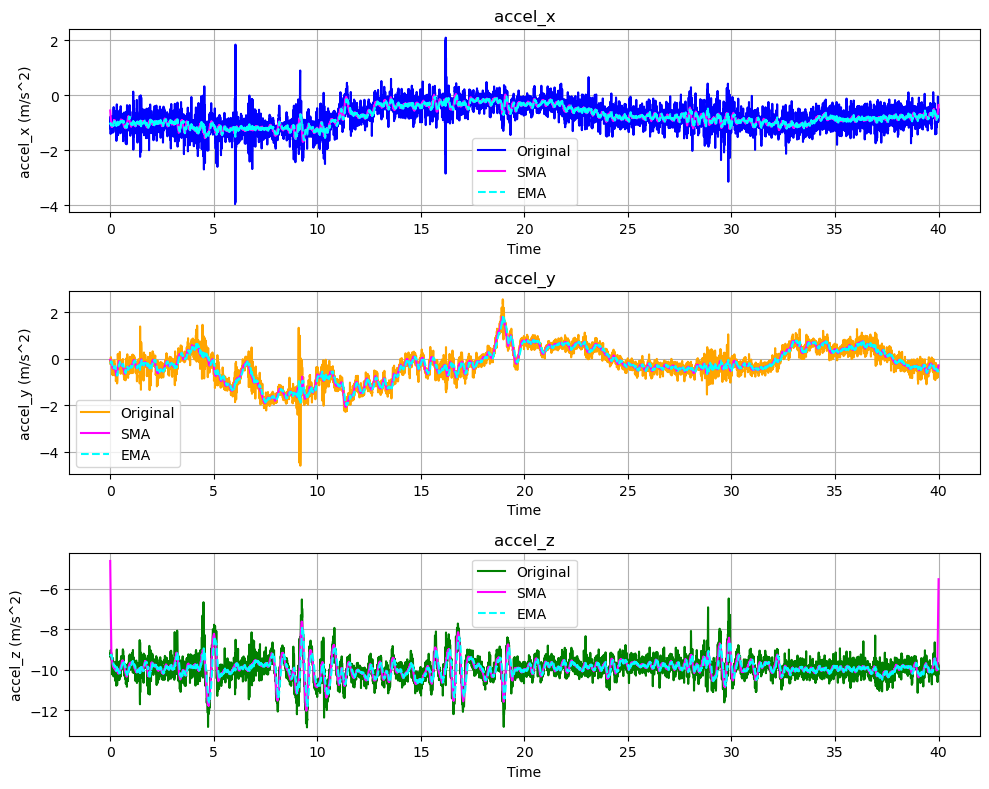

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas for EMA calculation

# Function to read the binary file containing acceleration data
# Assuming you have these files, otherwise this code won't run as is
data_value = np.load('value10')
data_t = np.load('t10')


# Assuming data_t is a 1D array of timestamps
# Find the minimum and maximum timestamps
min_time = np.min(data_t)
max_time = np.max(data_t)

# Calculate the range of time
time_range = max_time - min_time

# Normalize the time data to be between 0 and 40 seconds
data_t_normalized = ((data_t - min_time) / time_range) * 40
data_t_list = data_t_normalized.tolist()

df_time =  pd.DataFrame(data_t_list, columns=['timestamp'])


# Extracting individual components of acceleration
accel_x = data_value[:, 0]
accel_y = data_value[:, 1]
accel_z = data_value[:, 2]


# Simple Moving Average Function
def simple_moving_average(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

# Exponential Moving Average Function
def exponential_moving_average(data, window_size):
    return pd.Series(data).ewm(span=window_size, adjust=False).mean().to_numpy()


# Applying SMA and EMA
window_size = 20  # Example window size
sma_accel_x = simple_moving_average(accel_x, window_size)
ema_accel_x = exponential_moving_average(accel_x, window_size)
 
sma_accel_y = simple_moving_average(accel_y, window_size)
ema_accel_y = exponential_moving_average(accel_y, window_size)
 
sma_accel_z = simple_moving_average(accel_z, window_size)
ema_accel_z = exponential_moving_average(accel_z, window_size)

 
# Plotting the acceleration data with SMA and EMA
plt.figure(figsize=(10, 8))


titles = ['accel_x', 'accel_y', 'accel_z']
colors = ['blue', 'orange', 'green']
data_sets = [(accel_x, sma_accel_x, ema_accel_x),
             (accel_y, sma_accel_y, ema_accel_y),
             (accel_z, sma_accel_z, ema_accel_z)]


for i, (data, sma_data, ema_data) in enumerate(data_sets):
    plt.subplot(3, 1, i+1)
    plt.plot(data_t_normalized, data, label='Original', color=colors[i])
    plt.plot(data_t_normalized, sma_data, label='SMA', color='magenta')
    plt.plot(data_t_normalized, ema_data, label='EMA', color='cyan', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel(f'{titles[i]} (m/s^2)')
    plt.title(titles[i])
    plt.legend()
    plt.grid(True)


plt.tight_layout()
plt.show()



In [12]:
# Combine the data in a list
combined_data = list(zip( accel_y, data_t_normalized))

series2_data = data_value[:, 1]
set10 = []
set10_A = []
set10_B = []
x = 0


for data_point, time in combined_data :
    if time > 1.8 and time < 8.8:
        if data_point < -1 or data_point > 0.09:
            morton = calculateMortonFromXYAccelerationFloats(x, data_point)
            set10_A.append(morton)
            time_norm = time -1.8
            set10.append({'morton': morton, 'timestamp':time_norm})
            group_A.append(morton)
        else:
            morton = calculateMortonFromXYAccelerationFloats(x, data_point)
            set10_B.append(morton)
            time_norm = time -1.8
            set10.append({'morton': morton, 'timestamp':time_norm})
            group_B.append(morton)


    
df_set10 = pd.DataFrame(set10, columns=['morton','timestamp'])
print(df_set10)




       morton  timestamp
0     1046114   0.003061
1     1039936   0.009714
2     1045706   0.012970
3     1047626   0.016368
4     1048128   0.023021
...       ...        ...
1153  1013450   6.975777
1154  1012928   6.982431
1155  1012840   6.989084
1156  1012810   6.995738
1157  1012842   6.998993

[1158 rows x 2 columns]


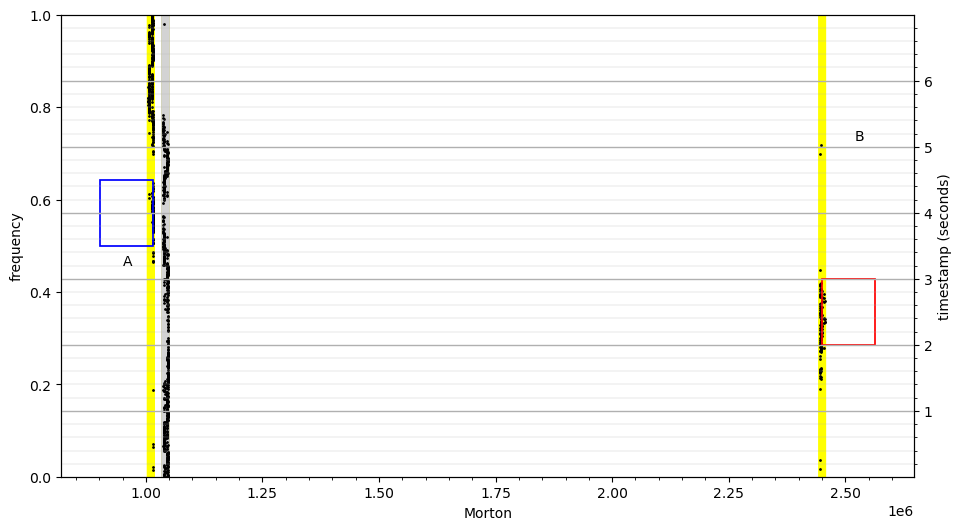

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as patches

data1 = [set10_A, set10_B]
data_colors = ['yellow', 'lightgray']

morton10 = df_set10['morton']
timestamp_seconds = df_set10['timestamp']



plt.figure(figsize=(11, 6))  # Adjust figure size as needed
plt.xlabel('Morton')
plt.ylabel('frequency')
plt.ylim((0, 1))
#plt.xticks(np.arange(min(morton40), max(morton40), 0.5e6))

#Plot the occurrences as vertical lines instead of horizontal
#plt.vlines(morton40, 0, 1, colors='lightgrey', linestyles='solid',linewidth = 4)
plt.eventplot(data1, orientation='horizontal', colors= data_colors, lineoffsets=[0.5, 0.5])
#Create a second y-axis for the timestamps
ax2 = plt.twinx()
ax2.set_ylabel('timestamp (seconds)')
#Set the limit for the timestamp y-axis to align with the data
ax2.set_ylim([min(timestamp_seconds), max(timestamp_seconds)])
ax2.grid(which = "major", linewidth = 1)
ax2.grid(which = "minor", linewidth = 0.2)
ax2.minorticks_on()
#plt.ylim(22, 29.4) #Zoomed in where we think the lane change is happening 
#plt.xlim(1.03e6, 1.05e6)
#Plot the timestamps on this new y-axis, aligned with the occurrences on the left y-axis
ax2.scatter(morton10, timestamp_seconds, color='black', s=1)  # Adjust size of dots



# Draw boxes 
plt.text(0.95*1e6, 3.2, 'A')
lower = plt.Rectangle( (0.902*1e6, 3.5), 1.14e5, 1, linewidth=1.25, edgecolor="blue", facecolor='none')
plt.text(2.52*1e6, 5.1, 'B')
upper = plt.Rectangle( (2.45*1e6, 2), 1.14e5, 1, linewidth=1.25, edgecolor="red", facecolor='none')

plt.gca().add_patch(lower)
plt.gca().add_patch(upper)

plt.show()

2.5 sec long; threshold -1 and 0.5

Set 6 from chunk 1

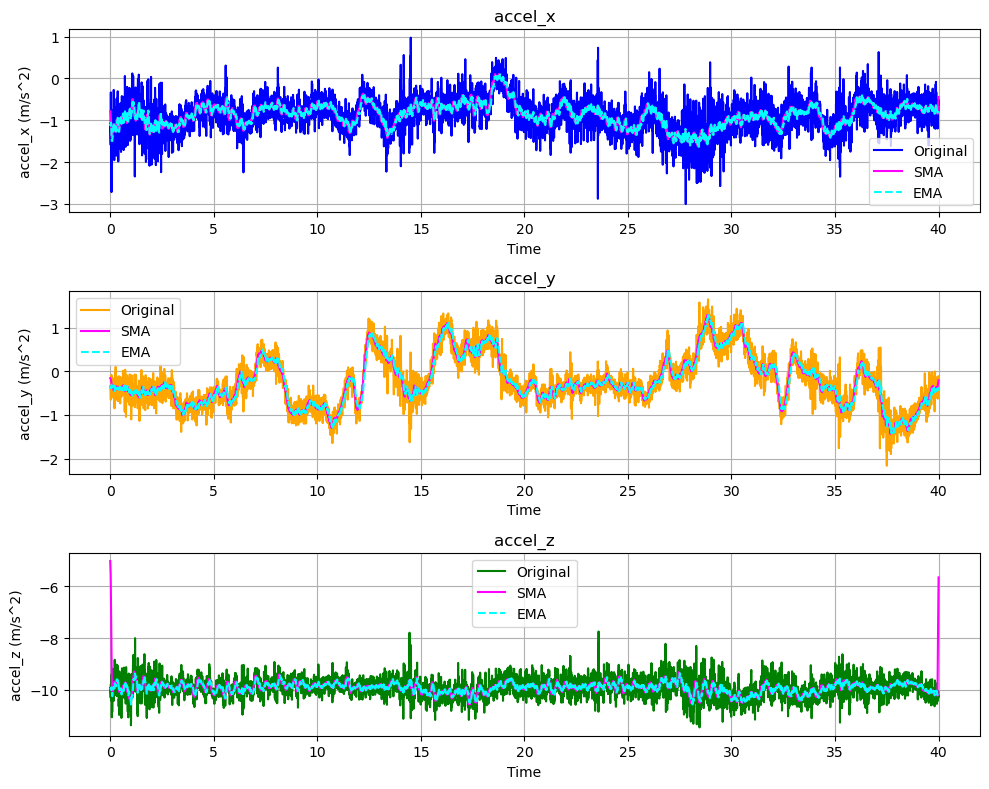

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas for EMA calculation

# Function to read the binary file containing acceleration data
# Assuming you have these files, otherwise this code won't run as is
data_value = np.load('value6')
data_t = np.load('t6')


# Assuming data_t is a 1D array of timestamps
# Find the minimum and maximum timestamps
min_time = np.min(data_t)
max_time = np.max(data_t)

# Calculate the range of time
time_range = max_time - min_time

# Normalize the time data to be between 0 and 40 seconds
data_t_normalized = ((data_t - min_time) / time_range) * 40
data_t_list = data_t_normalized.tolist()

df_time =  pd.DataFrame(data_t_list, columns=['timestamp'])


# Extracting individual components of acceleration
accel_x = data_value[:, 0]
accel_y = data_value[:, 1]
accel_z = data_value[:, 2]


# Simple Moving Average Function
def simple_moving_average(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

# Exponential Moving Average Function
def exponential_moving_average(data, window_size):
    return pd.Series(data).ewm(span=window_size, adjust=False).mean().to_numpy()


# Applying SMA and EMA
window_size = 20  # Example window size
sma_accel_x = simple_moving_average(accel_x, window_size)
ema_accel_x = exponential_moving_average(accel_x, window_size)
 
sma_accel_y = simple_moving_average(accel_y, window_size)
ema_accel_y = exponential_moving_average(accel_y, window_size)
 
sma_accel_z = simple_moving_average(accel_z, window_size)
ema_accel_z = exponential_moving_average(accel_z, window_size)

 
# Plotting the acceleration data with SMA and EMA
plt.figure(figsize=(10, 8))


titles = ['accel_x', 'accel_y', 'accel_z']
colors = ['blue', 'orange', 'green']
data_sets = [(accel_x, sma_accel_x, ema_accel_x),
             (accel_y, sma_accel_y, ema_accel_y),
             (accel_z, sma_accel_z, ema_accel_z)]


for i, (data, sma_data, ema_data) in enumerate(data_sets):
    plt.subplot(3, 1, i+1)
    plt.plot(data_t_normalized, data, label='Original', color=colors[i])
    plt.plot(data_t_normalized, sma_data, label='SMA', color='magenta')
    plt.plot(data_t_normalized, ema_data, label='EMA', color='cyan', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel(f'{titles[i]} (m/s^2)')
    plt.title(titles[i])
    plt.legend()
    plt.grid(True)


plt.tight_layout()
plt.show()



In [15]:
# Combine the data in a list
combined_data = list(zip( accel_y, data_t_normalized))

series2_data = data_value[:, 1]
set6_1 = []
set6_A1 = []
set6_B1 = []
x = 0


for data_point, time in combined_data :
    if time > 10 and time < 17:
        if data_point < -1 or data_point > 0.09:
            morton = calculateMortonFromXYAccelerationFloats(x, data_point)
            set6_A1.append(morton)
            time_norm = time -10
            set6_1.append({'morton': morton, 'timestamp':time_norm})
            group_A.append(morton)
        else:
            morton = calculateMortonFromXYAccelerationFloats(x, data_point)
            set6_B1.append(morton)
            time_norm = time -10
            set6_1.append({'morton': morton, 'timestamp':time_norm})
            group_B.append(morton)


    
df_set6_1 = pd.DataFrame(set6_1, columns=['morton','timestamp'])
print(df_set6_1)




       morton  timestamp
0     1039426   0.004221
1     1039554   0.010870
2     1039584   0.017520
3     1037922   0.024169
4     1037898   0.030819
...       ...        ...
1153  2446944   6.972853
1154  1048138   6.979503
1155  1047658   6.986152
1156  1048170   6.992802
1157  2446530   6.999451

[1158 rows x 2 columns]


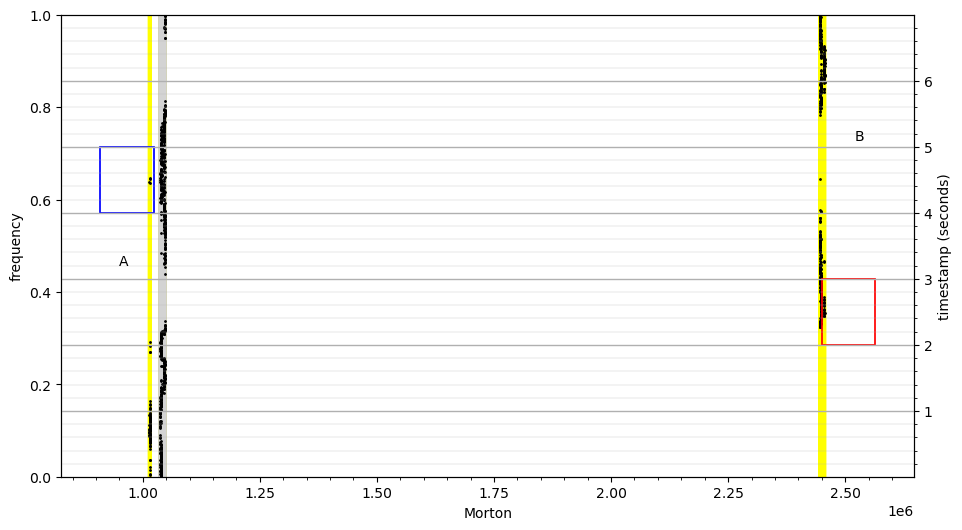

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as patches

data1 = [set6_A1, set6_B1]
data_colors = ['yellow', 'lightgray']

morton6_1 = df_set6_1['morton']
timestamp_seconds = df_set6_1['timestamp']



plt.figure(figsize=(11, 6))  # Adjust figure size as needed
plt.xlabel('Morton')
plt.ylabel('frequency')
plt.ylim((0, 1))
#plt.xticks(np.arange(min(morton40), max(morton40), 0.5e6))

#Plot the occurrences as vertical lines instead of horizontal
#plt.vlines(morton40, 0, 1, colors='lightgrey', linestyles='solid',linewidth = 4)
plt.eventplot(data1, orientation='horizontal', colors= data_colors, lineoffsets=[0.5, 0.5])
#Create a second y-axis for the timestamps
ax2 = plt.twinx()
ax2.set_ylabel('timestamp (seconds)')
#Set the limit for the timestamp y-axis to align with the data
ax2.set_ylim([min(timestamp_seconds), max(timestamp_seconds)])
ax2.grid(which = "major", linewidth = 1)
ax2.grid(which = "minor", linewidth = 0.2)
ax2.minorticks_on()
#plt.ylim(22, 29.4) #Zoomed in where we think the lane change is happening 
#plt.xlim(1.03e6, 1.05e6)
#Plot the timestamps on this new y-axis, aligned with the occurrences on the left y-axis
ax2.scatter(morton6_1, timestamp_seconds, color='black', s=1)  # Adjust size of dots

# Draw boxes 
plt.text(0.95*1e6, 3.2, 'A')
lower = plt.Rectangle( (0.909*1e6, 4), 1.14e5, 1, linewidth=1.25, edgecolor="blue", facecolor='none')
plt.text(2.52*1e6, 5.1, 'B')
upper = plt.Rectangle( (2.45*1e6, 2), 1.14e5, 1, linewidth=1.25, edgecolor="red", facecolor='none')

plt.gca().add_patch(lower)
plt.gca().add_patch(upper)


plt.show()

3 sec long: threshold -1 and 0.8

Set 27 from chunk 1

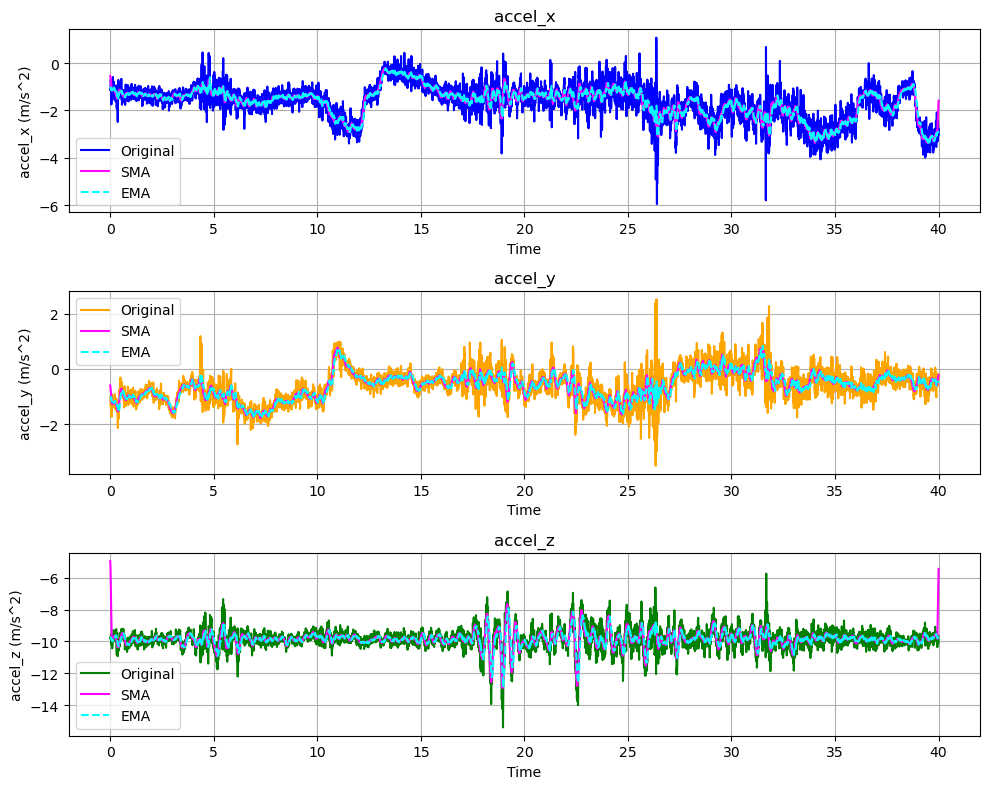

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas for EMA calculation

# Function to read the binary file containing acceleration data
# Assuming you have these files, otherwise this code won't run as is
data_value = np.load('value27')
data_t = np.load('t27')


# Assuming data_t is a 1D array of timestamps
# Find the minimum and maximum timestamps
min_time = np.min(data_t)
max_time = np.max(data_t)

# Calculate the range of time
time_range = max_time - min_time

# Normalize the time data to be between 0 and 40 seconds
data_t_normalized = ((data_t - min_time) / time_range) * 40
data_t_list = data_t_normalized.tolist()

df_time =  pd.DataFrame(data_t_list, columns=['timestamp'])


# Extracting individual components of acceleration
accel_x = data_value[:, 0]
accel_y = data_value[:, 1]
accel_z = data_value[:, 2]


# Simple Moving Average Function
def simple_moving_average(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

# Exponential Moving Average Function
def exponential_moving_average(data, window_size):
    return pd.Series(data).ewm(span=window_size, adjust=False).mean().to_numpy()


# Applying SMA and EMA
window_size = 20  # Example window size
sma_accel_x = simple_moving_average(accel_x, window_size)
ema_accel_x = exponential_moving_average(accel_x, window_size)
 
sma_accel_y = simple_moving_average(accel_y, window_size)
ema_accel_y = exponential_moving_average(accel_y, window_size)
 
sma_accel_z = simple_moving_average(accel_z, window_size)
ema_accel_z = exponential_moving_average(accel_z, window_size)

 
# Plotting the acceleration data with SMA and EMA
plt.figure(figsize=(10, 8))


titles = ['accel_x', 'accel_y', 'accel_z']
colors = ['blue', 'orange', 'green']
data_sets = [(accel_x, sma_accel_x, ema_accel_x),
             (accel_y, sma_accel_y, ema_accel_y),
             (accel_z, sma_accel_z, ema_accel_z)]


for i, (data, sma_data, ema_data) in enumerate(data_sets):
    plt.subplot(3, 1, i+1)
    plt.plot(data_t_normalized, data, label='Original', color=colors[i])
    plt.plot(data_t_normalized, sma_data, label='SMA', color='magenta')
    plt.plot(data_t_normalized, ema_data, label='EMA', color='cyan', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel(f'{titles[i]} (m/s^2)')
    plt.title(titles[i])
    plt.legend()
    plt.grid(True)


plt.tight_layout()
plt.show()



In [18]:
# Combine the data in a list
combined_data = list(zip( accel_y, data_t_normalized))

series2_data = data_value[:, 1]
set27 = []
set27_A = []
set27_B = []
x = 0


for data_point, time in combined_data :
    if time > 2 and time < 9:
        if data_point < -1 or data_point > 0.09:
            morton = calculateMortonFromXYAccelerationFloats(x, data_point)
            set27_A.append(morton)
            time_norm = time -2
            set27.append({'morton': morton, 'timestamp':time_norm})
            group_A.append(morton)
        else:
            morton = calculateMortonFromXYAccelerationFloats(x, data_point)
            set27_B.append(morton)
            time_norm = time -2
            set27.append({'morton': morton, 'timestamp':time_norm})
            group_B.append(morton)


    
df_set27 = pd.DataFrame(set27, columns=['morton','timestamp'])
print(df_set27)




       morton  timestamp
0     1039944   0.005555
1     1039968   0.012207
2     1037890   0.018859
3     1039434   0.025510
4     1037408   0.032162
...       ...        ...
1152  1037386   6.976523
1153  1037536   6.979778
1154  1040066   6.983175
1155  1040106   6.989827
1156  1039432   6.996479

[1157 rows x 2 columns]


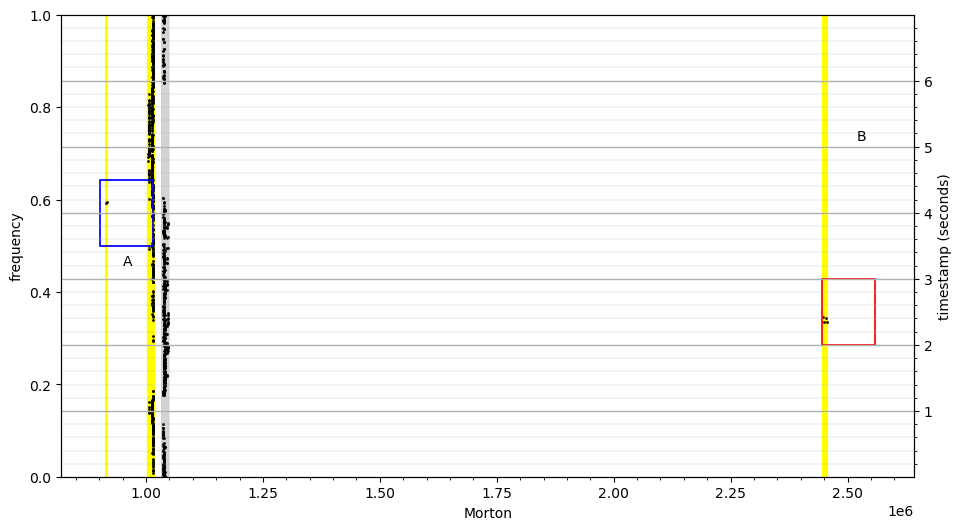

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as patches

data1 = [set27_A, set27_B]
data_colors = ['yellow', 'lightgray']

morton27 = df_set27['morton']
timestamp_seconds = df_set27['timestamp']



plt.figure(figsize=(11, 6))  # Adjust figure size as needed
plt.xlabel('Morton')
plt.ylabel('frequency')
plt.ylim((0, 1))
#plt.xticks(np.arange(min(morton40), max(morton40), 0.5e6))

#Plot the occurrences as vertical lines instead of horizontal
#plt.vlines(morton40, 0, 1, colors='lightgrey', linestyles='solid',linewidth = 4)
plt.eventplot(data1, orientation='horizontal', colors= data_colors, lineoffsets=[0.5, 0.5])
#Create a second y-axis for the timestamps
ax2 = plt.twinx()
ax2.set_ylabel('timestamp (seconds)')
#Set the limit for the timestamp y-axis to align with the data
ax2.set_ylim([min(timestamp_seconds), max(timestamp_seconds)])
ax2.grid(which = "major", linewidth = 1)
ax2.grid(which = "minor", linewidth = 0.2)
ax2.minorticks_on()
#plt.ylim(22, 29.4) #Zoomed in where we think the lane change is happening 
#plt.xlim(1.03e6, 1.05e6)
#Plot the timestamps on this new y-axis, aligned with the occurrences on the left y-axis
ax2.scatter(morton27, timestamp_seconds, color='black', s=1)  # Adjust size of dots


# Draw boxes 
plt.text(0.95*1e6, 3.2, 'A')
lower = plt.Rectangle( (0.902*1e6, 3.5), 1.14e5, 1, linewidth=1.25, edgecolor="blue", facecolor='none')
plt.text(2.52*1e6, 5.1, 'B')
upper = plt.Rectangle( (2.445*1e6, 2), 1.14e5, 1, linewidth=1.25, edgecolor="red", facecolor='none')

plt.gca().add_patch(lower)
plt.gca().add_patch(upper)


plt.show()

2.5 sec long; threshold -1.5 and 0.09

Set 22 from chunk 2

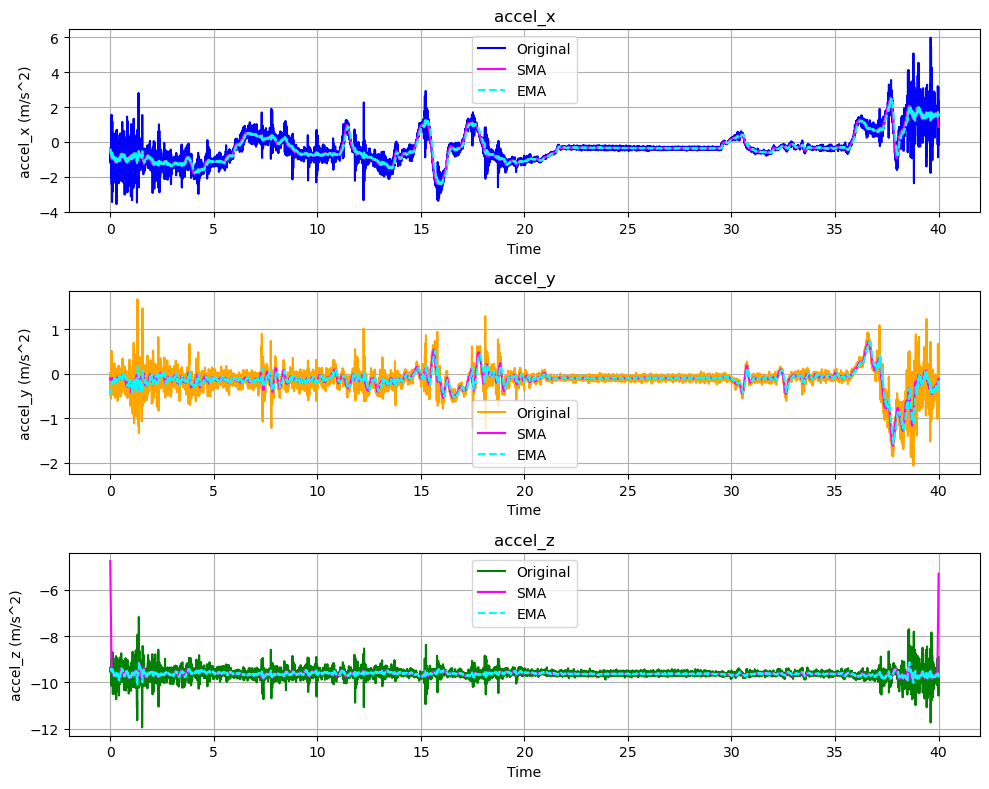

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas for EMA calculation

# Function to read the binary file containing acceleration data
# Assuming you have these files, otherwise this code won't run as is
data_value = np.load('value22_2018-10-09--15-48-37')
data_t = np.load('t22_2018-10-09--15-48-37')


# Assuming data_t is a 1D array of timestamps
# Find the minimum and maximum timestamps
min_time = np.min(data_t)
max_time = np.max(data_t)

# Calculate the range of time
time_range = max_time - min_time

# Normalize the time data to be between 0 and 40 seconds
data_t_normalized = ((data_t - min_time) / time_range) * 40
data_t_list = data_t_normalized.tolist()

df_time =  pd.DataFrame(data_t_list, columns=['timestamp'])


# Extracting individual components of acceleration
accel_x = data_value[:, 0]
accel_y = data_value[:, 1]
accel_z = data_value[:, 2]


# Simple Moving Average Function
def simple_moving_average(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

# Exponential Moving Average Function
def exponential_moving_average(data, window_size):
    return pd.Series(data).ewm(span=window_size, adjust=False).mean().to_numpy()


# Applying SMA and EMA
window_size = 20  # Example window size
sma_accel_x = simple_moving_average(accel_x, window_size)
ema_accel_x = exponential_moving_average(accel_x, window_size)
 
sma_accel_y = simple_moving_average(accel_y, window_size)
ema_accel_y = exponential_moving_average(accel_y, window_size)
 
sma_accel_z = simple_moving_average(accel_z, window_size)
ema_accel_z = exponential_moving_average(accel_z, window_size)

 
# Plotting the acceleration data with SMA and EMA
plt.figure(figsize=(10, 8))


titles = ['accel_x', 'accel_y', 'accel_z']
colors = ['blue', 'orange', 'green']
data_sets = [(accel_x, sma_accel_x, ema_accel_x),
             (accel_y, sma_accel_y, ema_accel_y),
             (accel_z, sma_accel_z, ema_accel_z)]


for i, (data, sma_data, ema_data) in enumerate(data_sets):
    plt.subplot(3, 1, i+1)
    plt.plot(data_t_normalized, data, label='Original', color=colors[i])
    plt.plot(data_t_normalized, sma_data, label='SMA', color='magenta')
    plt.plot(data_t_normalized, ema_data, label='EMA', color='cyan', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel(f'{titles[i]} (m/s^2)')
    plt.title(titles[i])
    plt.legend()
    plt.grid(True)


plt.tight_layout()
plt.show()




In [21]:
# Combine the data in a list
combined_data = list(zip( accel_y, data_t_normalized))

series2_data = data_value[:, 1]
set22 = []
set22_A = []
set22_B = []
x = 0


for data_point, time in combined_data :
    if time > 34 and time < 41:
        if data_point < -1 or data_point > 0.09:
            morton = calculateMortonFromXYAccelerationFloats(x, data_point)
            set22_A.append(morton)
            time_norm = time -34
            set22.append({'morton': morton, 'timestamp':time_norm})
            group_A.append(morton)
        else:
            morton = calculateMortonFromXYAccelerationFloats(x, data_point)
            set22_B.append(morton)
            time_norm = time -34
            set22.append({'morton': morton, 'timestamp':time_norm})
            group_B.append(morton)


    
df_set22 = pd.DataFrame(set22, columns=['morton','timestamp'])
print(df_set22)




      morton  timestamp
0    1047754   0.001607
1    1047744   0.008017
2    1047752   0.014406
3    1047618   0.020796
4    1047618   0.027185
..       ...        ...
934  1048130   5.974422
935  2446560   5.980811
936  1047754   5.987221
937  1039936   5.993611
938  1047744   6.000000

[939 rows x 2 columns]


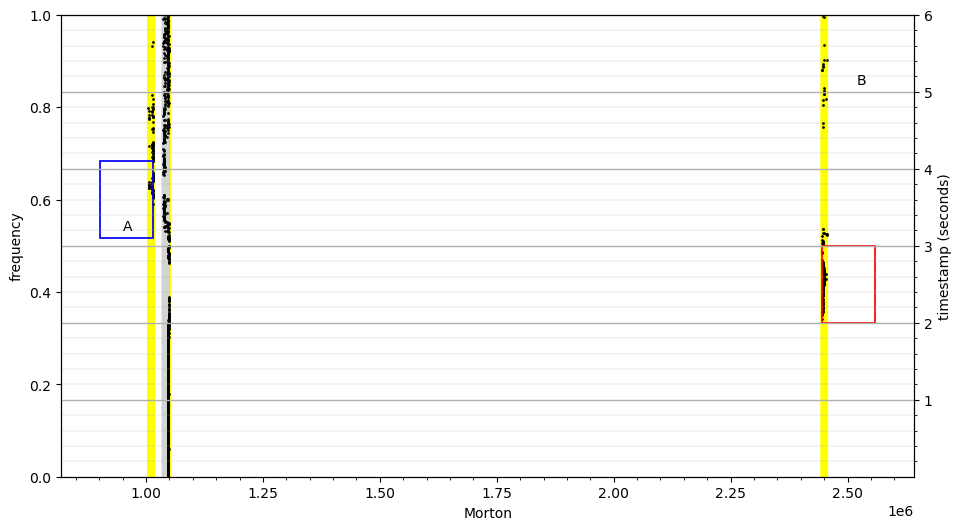

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as patches

data1 = [set22_A, set22_B]
data_colors = ['yellow', 'lightgray']

morton22 = df_set22['morton']
timestamp_seconds = df_set22['timestamp']



plt.figure(figsize=(11, 6))  # Adjust figure size as needed
plt.xlabel('Morton')
plt.ylabel('frequency')
plt.ylim((0, 1))
#plt.xticks(np.arange(min(morton40), max(morton40), 0.5e6))

#Plot the occurrences as vertical lines instead of horizontal
#plt.vlines(morton40, 0, 1, colors='lightgrey', linestyles='solid',linewidth = 4)
plt.eventplot(data1, orientation='horizontal', colors= data_colors, lineoffsets=[0.5, 0.5])
#Create a second y-axis for the timestamps
ax2 = plt.twinx()
ax2.set_ylabel('timestamp (seconds)')
#Set the limit for the timestamp y-axis to align with the data
ax2.set_ylim([min(timestamp_seconds), max(timestamp_seconds)])
ax2.grid(which = "major", linewidth = 1)
ax2.grid(which = "minor", linewidth = 0.2)
ax2.minorticks_on()
#plt.ylim(22, 29.4) #Zoomed in where we think the lane change is happening 
#plt.xlim(1.03e6, 1.05e6)
#Plot the timestamps on this new y-axis, aligned with the occurrences on the left y-axis
ax2.scatter(morton22, timestamp_seconds, color='black', s=1)  # Adjust size of dots



# Draw boxes 
plt.text(0.95*1e6, 3.2, 'A')
lower = plt.Rectangle( (0.902*1e6, 3.1), 1.14e5, 1, linewidth=1.25, edgecolor="blue", facecolor='none')
plt.text(2.52*1e6, 5.1, 'B')
upper = plt.Rectangle( (2.445*1e6, 2), 1.14e5, 1, linewidth=1.25, edgecolor="red", facecolor='none')

plt.gca().add_patch(lower)
plt.gca().add_patch(upper)


plt.show()

2.1 sec lomg; threshold -1 and o.5

Set 9 from chunk 2

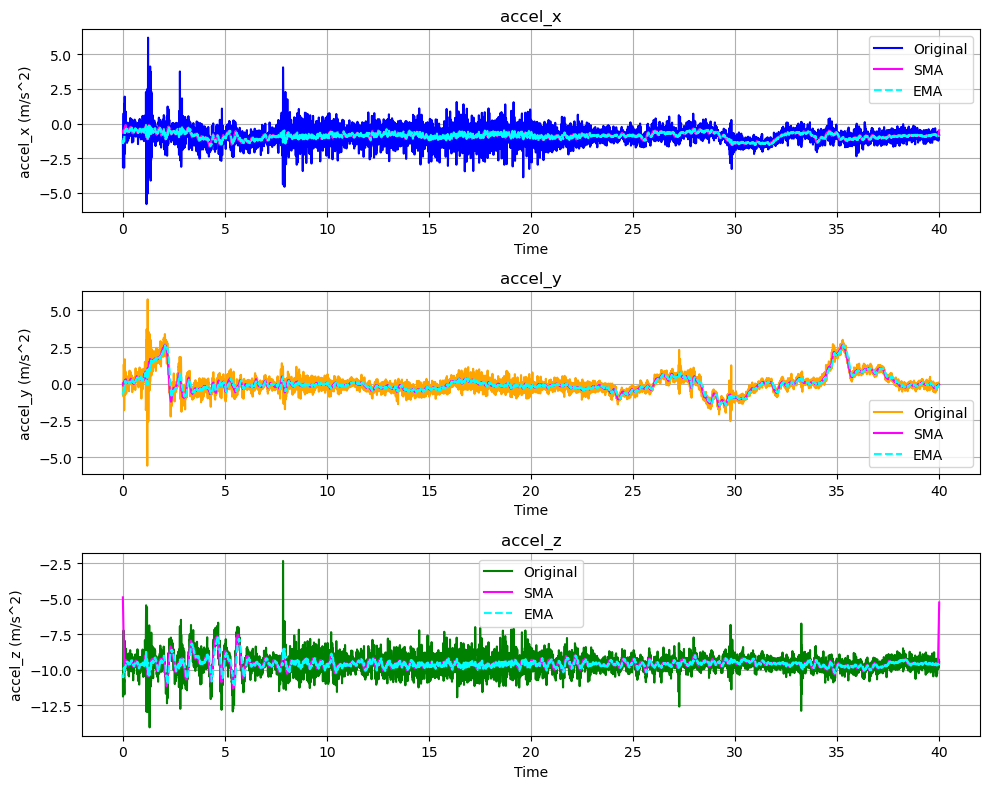

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas for EMA calculation

# Function to read the binary file containing acceleration data
# Assuming you have these files, otherwise this code won't run as is
data_value = np.load('value9_2018-10-09--14-06-32')
data_t = np.load('t9_2018-10-09--14-06-32')


# Assuming data_t is a 1D array of timestamps
# Find the minimum and maximum timestamps
min_time = np.min(data_t)
max_time = np.max(data_t)

# Calculate the range of time
time_range = max_time - min_time

# Normalize the time data to be between 0 and 40 seconds
data_t_normalized = ((data_t - min_time) / time_range) * 40
data_t_list = data_t_normalized.tolist()

df_time =  pd.DataFrame(data_t_list, columns=['timestamp'])


# Extracting individual components of acceleration
accel_x = data_value[:, 0]
accel_y = data_value[:, 1]
accel_z = data_value[:, 2]


# Simple Moving Average Function
def simple_moving_average(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

# Exponential Moving Average Function
def exponential_moving_average(data, window_size):
    return pd.Series(data).ewm(span=window_size, adjust=False).mean().to_numpy()


# Applying SMA and EMA
window_size = 20  # Example window size
sma_accel_x = simple_moving_average(accel_x, window_size)
ema_accel_x = exponential_moving_average(accel_x, window_size)
 
sma_accel_y = simple_moving_average(accel_y, window_size)
ema_accel_y = exponential_moving_average(accel_y, window_size)
 
sma_accel_z = simple_moving_average(accel_z, window_size)
ema_accel_z = exponential_moving_average(accel_z, window_size)

 
# Plotting the acceleration data with SMA and EMA
plt.figure(figsize=(10, 8))


titles = ['accel_x', 'accel_y', 'accel_z']
colors = ['blue', 'orange', 'green']
data_sets = [(accel_x, sma_accel_x, ema_accel_x),
             (accel_y, sma_accel_y, ema_accel_y),
             (accel_z, sma_accel_z, ema_accel_z)]


for i, (data, sma_data, ema_data) in enumerate(data_sets):
    plt.subplot(3, 1, i+1)
    plt.plot(data_t_normalized, data, label='Original', color=colors[i])
    plt.plot(data_t_normalized, sma_data, label='SMA', color='magenta')
    plt.plot(data_t_normalized, ema_data, label='EMA', color='cyan', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel(f'{titles[i]} (m/s^2)')
    plt.title(titles[i])
    plt.legend()
    plt.grid(True)


plt.tight_layout()
plt.show()



In [24]:
# Combine the data in a list
combined_data = list(zip( accel_y, data_t_normalized))

series2_data = data_value[:, 1]
set9 = []
set9_A = []
set9_B = []
x = 0


for data_point, time in combined_data :
    if time > 25 and time < 32:
        if data_point < -1 or data_point > 0.09:
            morton = calculateMortonFromXYAccelerationFloats(x, data_point)
            set9_A.append(morton)
            time_norm = time -25
            set9.append({'morton': morton, 'timestamp':time_norm})
            group_A.append(morton)
        else:
            morton = calculateMortonFromXYAccelerationFloats(x, data_point)
            set9_B.append(morton)
            time_norm = time -25
            set9.append({'morton': morton, 'timestamp':time_norm})
            group_B.append(morton)


    
df_set9 = pd.DataFrame(set9, columns=['morton','timestamp'])
print(df_set9)




       morton  timestamp
0     1040098   0.005498
1     1039458   0.011888
2     1046216   0.018278
3     1040072   0.024689
4     1039970   0.031079
...       ...        ...
1089  1039426   6.971789
1090  1039594   6.978179
1091  1045608   6.984569
1092  1045706   6.990980
1093  1038058   6.997370

[1094 rows x 2 columns]


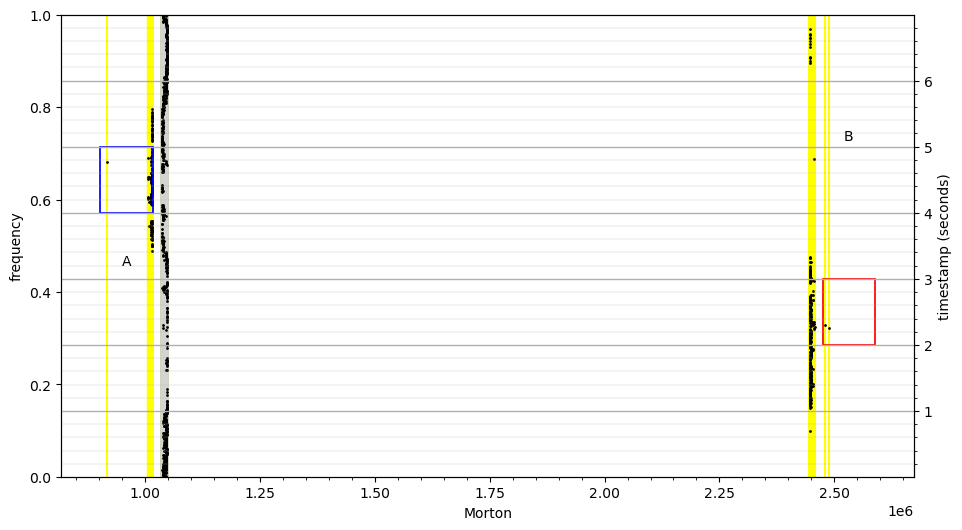

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as patches

data1 = [set9_A, set9_B]
data_colors = ['yellow', 'lightgray']

morton9 = df_set9['morton']
timestamp_seconds = df_set9['timestamp']



plt.figure(figsize=(11, 6))  # Adjust figure size as needed
plt.xlabel('Morton')
plt.ylabel('frequency')
plt.ylim((0, 1))
#plt.xticks(np.arange(min(morton40), max(morton40), 0.5e6))

#Plot the occurrences as vertical lines instead of horizontal
#plt.vlines(morton40, 0, 1, colors='lightgrey', linestyles='solid',linewidth = 4)
plt.eventplot(data1, orientation='horizontal', colors= data_colors, lineoffsets=[0.5, 0.5])
#Create a second y-axis for the timestamps
ax2 = plt.twinx()
ax2.set_ylabel('timestamp (seconds)')
#Set the limit for the timestamp y-axis to align with the data
ax2.set_ylim([min(timestamp_seconds), max(timestamp_seconds)])
ax2.grid(which = "major", linewidth = 1)
ax2.grid(which = "minor", linewidth = 0.2)
ax2.minorticks_on()
#plt.ylim(22, 29.4) #Zoomed in where we think the lane change is happening 
#plt.xlim(1.03e6, 1.05e6)
#Plot the timestamps on this new y-axis, aligned with the occurrences on the left y-axis
ax2.scatter(morton9, timestamp_seconds, color='black', s=1)  # Adjust size of dots



# Draw boxes 
plt.text(0.95*1e6, 3.2, 'A')
lower = plt.Rectangle( (0.902*1e6, 4), 1.14e5, 1, linewidth=1.25, edgecolor="blue", facecolor='none')
plt.text(2.52*1e6, 5.1, 'B')
upper = plt.Rectangle( (2.475*1e6, 2), 1.14e5, 1, linewidth=1.25, edgecolor="red", facecolor='none')

plt.gca().add_patch(lower)
plt.gca().add_patch(upper)


plt.show()

We stacked up all the right lane changes and were able to draw all the box A for different durations in the same graph

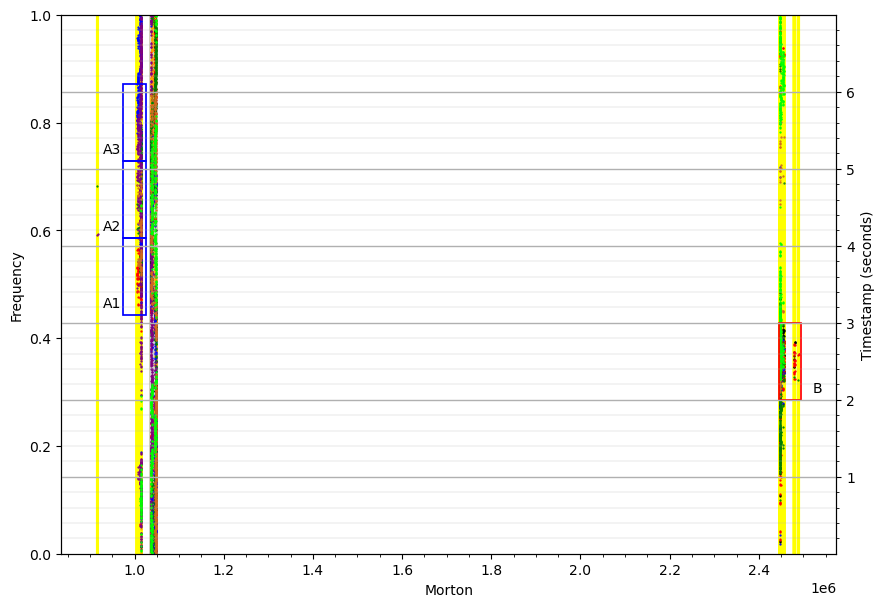

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Highlighting the data we are interested in
data1 = [group_A, group_B]
data_colors = ['yellow', 'lightgray']

# Assuming df_seg1, df_seg2, df_seg3, df_seg4, df_lane_change_morton are predefined DataFrames
# Assuming times_for_maneuver_lc is predefined

# Extract data from segments
data_segments = [df_set40, df_set3, df_set7, df_set10, df_set9, df_set27, df_set22, df_set6_1]
data = []
timestamp_seconds = []
for df in data_segments:
    data.append(df['morton'])
    timestamp = df['timestamp']
    timestamp_seconds.append(timestamp)

# Calculate global timestamp limits
min_timestamp = min(min(ts) for ts in timestamp_seconds)
max_timestamp = max(max(ts) for ts in timestamp_seconds)

# Plotting
plt.figure(figsize=(10, 7))

plt.eventplot(data1, orientation='horizontal', colors=data_colors, lineoffsets=[0.5, 0.5])

plt.xlabel('Morton')
plt.ylabel('Frequency')
plt.ylim((0, 1))
#plt.xlim(1e6, 1e6)
#plt.xlim(1e6, 1e6)
#plt.xlim(2.4e6, 2.5e6)

# Create a second y-axis for timestamps
ax2 = plt.twinx()
ax2.set_ylabel('Timestamp (seconds)')
ax2.set_ylim([min_timestamp, max_timestamp])
ax2.grid(which = "major", linewidth = 1)
ax2.grid(which = "minor", linewidth = 0.2)
ax2.minorticks_on()


# Plot timestamps as scatter points
colors = ['black', 'red', 'orange', 'blue','green','purple','chocolate','lime']
for ds, color, ts in zip(data, colors, timestamp_seconds):
    ax2.scatter(ds, ts, color=color, s=0.4)

#  Draw boxes

plt.text(0.93*1e6, 3.2, 'A1')
lower = plt.Rectangle( (0.975*1e6, 3.1), 0.5e5, 1, linewidth=1.25, edgecolor="blue", facecolor='none')

plt.text(0.93*1e6, 4.2, 'A2')
lower1 = plt.Rectangle( (0.975*1e6, 4.1), 0.5e5, 1, linewidth=1.25, edgecolor="blue", facecolor='none')

plt.text(0.93*1e6, 5.2, 'A3')
lower2 = plt.Rectangle( (0.975*1e6, 5.1), 0.5e5, 1, linewidth=1.25, edgecolor="blue", facecolor='none')

plt.text(2.52*1e6, 2.1, 'B')
upper = plt.Rectangle( (2.445*1e6, 2), 0.5e5, 1, linewidth=1.25, edgecolor="red", facecolor='none')

plt.gca().add_patch(lower)
plt.gca().add_patch(lower1)
plt.gca().add_patch(lower2)
plt.gca().add_patch(upper)


plt.show()

In [ ]:
Zoomed into box As

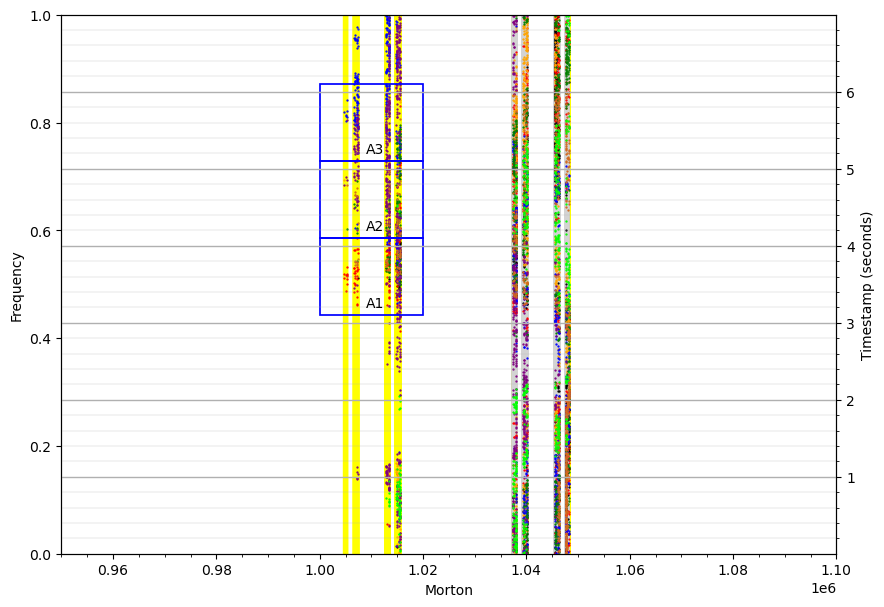

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Highlighting the data we are interested in
data1 = [group_A, group_B]
data_colors = ['yellow', 'lightgray']

# Assuming df_seg1, df_seg2, df_seg3, df_seg4, df_lane_change_morton are predefined DataFrames
# Assuming times_for_maneuver_lc is predefined

# Extract data from segments
data_segments = [df_set40, df_set3, df_set7, df_set10, df_set9, df_set27, df_set22, df_set6_1]
data = []
timestamp_seconds = []
for df in data_segments:
    data.append(df['morton'])
    timestamp = df['timestamp']
    timestamp_seconds.append(timestamp)

# Calculate global timestamp limits
min_timestamp = min(min(ts) for ts in timestamp_seconds)
max_timestamp = max(max(ts) for ts in timestamp_seconds)

# Plotting
plt.figure(figsize=(10, 7))

plt.eventplot(data1, orientation='horizontal', colors=data_colors, lineoffsets=[0.5, 0.5])

plt.xlabel('Morton')
plt.ylabel('Frequency')
plt.ylim((0, 1))
#plt.xlim(1e6, 1e6)
plt.xlim(0.95e6, 1.1e6)
#plt.xlim(2.4e6, 2.5e6)

# Create a second y-axis for timestamps
ax2 = plt.twinx()
ax2.set_ylabel('Timestamp (seconds)')
ax2.set_ylim([min_timestamp, max_timestamp])
ax2.grid(which = "major", linewidth = 1)
ax2.grid(which = "minor", linewidth = 0.2)
ax2.minorticks_on()


# Plot timestamps as scatter points
colors = ['black', 'red', 'orange', 'blue','green','purple','chocolate','lime']
for ds, color, ts in zip(data, colors, timestamp_seconds):
    ax2.scatter(ds, ts, color=color, s=0.4)

#  Draw boxes

plt.text(1.009*1e6, 3.2, 'A1')
lower = plt.Rectangle( (1*1e6, 3.1), 0.2e5, 1, linewidth=1.25, edgecolor="blue", facecolor='none')

plt.text(1.009*1e6, 4.2, 'A2')
lower1 = plt.Rectangle( (1*1e6, 4.1), 0.2e5, 1, linewidth=1.25, edgecolor="blue", facecolor='none')

plt.text(1.009*1e6, 5.2, 'A3')
lower2 = plt.Rectangle( (1*1e6, 5.1), 0.2e5, 1, linewidth=1.25, edgecolor="blue", facecolor='none')
"""
plt.text(2.52*1e6, 2.1, 'B')
upper = plt.Rectangle( (2.45*1e6, 2), 1.14e5, 1, linewidth=1.25, edgecolor="red", facecolor='none')
plt.gca().add_patch(upper)
"""
plt.gca().add_patch(lower)
plt.gca().add_patch(lower1)
plt.gca().add_patch(lower2)



plt.show()